# Literature Drug Response

In [98]:
import sys 
lab_path="/Users/andyzeng/Drive/Laptop/Dick_Lab/"
sys.path.append(lab_path+"AMLhierarchies/")
%load_ext rpy2.ipython

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%matplotlib inline
import copy
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import anndata as ad
import scipy
import seaborn as sns
sc.set_figure_params(scanpy=True, dpi_save=200)
#from SAM import SAM
import Hierarchy_Tools as tk

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [99]:
%%R -w 8 -h 4 --units in -r 200
require("survival")
library(tidyverse)
library(ggpubr)
library(survminer)

R[write to console]: Error in library(survminer) : there is no package called ‘survminer’




Error in library(survminer) : there is no package called ‘survminer’


# Load Prediction output

In [100]:
# hcat = sc.read_h5ad(lab_path+'AMLhierarchies/2_CIBERSORTx/signature_testing/3_fullproperLSPC/old_cDC/HierarchyCat_PC_NMF.h5ad')
# hcat

# Load CC90009 and JAK2 Response

In [101]:
fedresponse = pd.read_csv("Data/Fig6_AML_PDX_Response/PDX_Response_Fedratinib.csv").dropna()#.set_index('Patient')
fedresponse.Patient = fedresponse.Patient.astype('int')#.astype('str')
fedresponse = fedresponse.rename(columns={'RF Reduction':'Fed RF Reduction', 'BM Reduction':'Fed BM Reduction'})

In [102]:
CC90009response = pd.read_csv("Data/Fig6_AML_PDX_Response/PDX_Response_CC90009.csv").set_index('SampleID')
CC90009response = CC90009response.rename(columns={'RF_relative_reduction(%)':'CC90009 RF Reduction', 'BM_relative_reduction(%)':'CC90009 BM Reduction', 'Response':'CC90009 Response'})

In [103]:
#combined = hcat.obs[['PC1', 'PC2', 'Cluster']].append(bulk[bulk.obs.Response!='NA'].obs[['PC1', 'PC2', 'Cluster', 'Response', 'Patient_ID']])

In [104]:
bulk[bulk.obs['SampleType'] == 'Bulk']

View of AnnData object with n_obs × n_vars = 20 × 14
    obs: 'B-Absolute', 'CTL-Absolute', 'GMP-like-Absolute', 'LSPC-Cycle-Absolute', 'LSPC-Primed-Absolute', 'LSPC-Quiescent-Absolute', 'Mono-like-Absolute', 'Monocyte-Absolute', 'NK-Absolute', 'Plasma-Absolute', 'ProMono-like-Absolute', 'T-Absolute', 'cDC-Absolute', 'cDC-like-Absolute', 'GMP-like-Relative', 'LSPC-Cycle-Relative', 'LSPC-Primed-Relative', 'LSPC-Quiescent-Relative', 'Mono-like-Relative', 'ProMono-like-Relative', 'cDC-like-Relative', 'CIRM_ID', 'Patient_ID', 'Cohort', 'SampleType', 'Treatment', 'Response', 'Processing', 'STAT5', 'SRC', 'Mouse'

In [105]:
def load_fractions(dem_path):
    def scale_series(series): 
        return((series - np.mean(series))/np.std(series))
    def scale_series_mad(series): 
        return((series - np.median(series))/scipy.stats.median_absolute_deviation(series))

    # load CIBERSORT output
    dat = sc.read_csv(dem_path, first_column_names=True)
    dat = dat[:,~dat.var_names.isin(['P-value', 'Correlation', 'RMSE', 'Absolute score (sig.score)'])]
    dat.obs.index.rename('Sample', inplace=True)

    # add the absolute scores
    cell_type_scores = pd.DataFrame(dat.X, index=dat.obs_names, columns=dat.var_names+"-Absolute")
    dat.obs = dat.obs.merge(cell_type_scores, how = 'left', left_index=True, right_index=True)
    
    return dat

# PMH AML Samples 
lscbulk = tk.load_fractions("Data/Fig6_AML_PDX_Response/CIBERSORTx_Results_LSCbulk.csv")
cereblon = tk.load_fractions("Data/Fig6_AML_PDX_Response/CIBERSORTx_Results_Cereblon.csv")
# Fedratinib
bulk = tk.load_fractions("Data/Fig6_AML_PDX_Response/CIBERSORTx_Results_JAK2.csv")
bulk.obs = bulk.obs.join(pd.read_csv("Data/Fig6_AML_PDX_Response/JAK2_sampledata.csv").set_index('Sample'))
bulk = bulk[bulk.obs['SampleType'] == 'Bulk']
bulk = bulk[bulk.obs.drop_duplicates(subset=['Patient_ID']).index.values] # drop duplicates

# PMH AML Samples + Two extra bulk samples from Fedratinib RNA-seq
cat = ad.AnnData.concatenate(lscbulk, cereblon, bulk[bulk.obs.Patient_ID.isin(['100091', '90454'])], index_unique=None, batch_key='Cohort', batch_categories=['LSC1', 'CC90009', 'JAK2'])

# Normalize malignant proportions 
cat = cat[:,cat.var_names.isin(['LSPC-Quiescent', 'LSPC-Primed', 'LSPC-Cycle', 'GMP-like', 'ProMono-like', 'Mono-like', 'cDC-like'])]
cat.X = (cat.X.transpose() / cat.X.sum(axis=1)).transpose()

# Patient Annotations
anno = pd.read_csv(lab_path+"CIBERSORT/AML_LSC/phenodata_patientid.txt", sep='\t')
anno = anno.set_index('Sample').rename(columns={'Patient.ID':'Patient'})[['Patient']]
cat.obs = cat.obs.merge(anno, how='left', left_index=True, right_index=True)
cat.obs['Patient'] = np.where(cat.obs.Patient_ID.isin(['100091', '90454']), cat.obs.Patient_ID, cat.obs.Patient).astype('float')

# Add Fedratinib Responses
cat.obs = cat.obs.reset_index().merge(fedresponse, how='left', left_on = 'Patient', right_on = 'Patient').set_index('Sample')
cat.obs['Fedratinib'] = np.where(cat.obs['Fed Response'].isin(['NR', 'PR']), 'NR/PR', np.where(cat.obs['Fed Response'].isin(['R']), 'R', 'NA'))
# Add CC-90009 Responses
cat.obs = cat.obs.reset_index().merge(CC90009response, how='left', left_on = 'Patient', right_on = 'PatientID').set_index('Sample')
cat.obs['CC90009'] = np.where(cat.obs['CC90009 Response'].isin(['NR', 'PR']), 'NR/PR', np.where(cat.obs['CC90009 Response'].isin(['R']), 'R', 'NA'))

# drop duplicates
cat = cat[~cat.obs.index.isin(['LSC0034_Bl_Bulk', 'LSC0003_Bl_Bulk', 'LSC0037_Bl_Bulk', 'LSC0062_Bl_Bulk', 'LSC0077_Bl_Bulk', 'LSC0074_Bl_Bulk', 'LSC0010_Bl_Bulk'])]
cat.obs

/Users/andyzeng/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2492: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


,B-Absolute,CTL-Absolute,GMP-like-Absolute,LSPC-Cycle-Absolute,LSPC-Primed-Absolute,LSPC-Quiescent-Absolute,Mono-like-Absolute,Monocyte-Absolute,NK-Absolute,Plasma-Absolute,...,RF_CC90009,RF_Vehicle,RF_Pvalue,CC90009 RF Reduction,BM_CC90009,BM_Vehicle,BM_Pvalue,CC90009 BM Reduction,CC90009 Response,CC90009
Sample,,,,,,,,,,,,,,,,,,,,,
LSC0001_Bl_Bulk,0.129641,0.084778,7.494859,1.268523,0.000000,2.097598,0.000000,0.542465,0.415327,0.175965,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NA
LSC0004_Bl_Bulk,0.312419,0.000000,4.035892,0.000000,1.110485,4.727725,0.000000,0.511934,0.938947,0.392959,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NA
LSC0005_Bl_Bulk,0.701088,0.000000,0.356658,2.094053,0.095986,1.456185,8.019021,6.403949,0.778016,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NA
LSC0006_Bl_Bulk,0.236957,0.089242,3.020904,5.423254,0.000000,5.118757,3.507483,6.339745,0.453806,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NA
LSC0007_Bl_Bulk,1.383769,0.000000,0.204460,2.805789,0.847735,4.723894,5.935950,7.575315,0.455585,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CC31,0.217739,0.059943,0.979434,1.206571,6.414339,5.041229,0.000000,0.939143,0.222738,0.380299,...,0.01,2.47,0.160000,99.60,0.00,0.02,0.090000,100.00,too low,NA
CC32,0.635993,0.021322,9.214156,2.891359,0.690487,7.319177,1.118422,1.559950,1.302541,0.437364,...,2.62,54.52,0.020000,95.19,0.61,45.52,0.000003,98.66,R,R
CC33,0.626360,0.168095,12.135420,0.000000,2.792510,3.397467,2.194392,1.470818,1.310799,0.626633,...,3.20,81.77,0.000037,96.09,1.37,81.91,0.000012,98.33,R,R


In [106]:
# cat.obs = cat.obs.reset_index().merge(fedresponse, how='left', left_on = 'Patient', right_on = 'Patient').set_index('Sample')
# cat.obs = cat.obs.reset_index().merge(CC90009response, how='left', left_on = 'Patient', right_on = 'PatientID').set_index('Sample')
# #cat.obs['CC90009 Response'] = CC90009response['Response']
# #cat.obs['CC90009 Response'] = cat.obs['CC90009 Response'].fillna("NA")
# cat.obs

In [107]:
# cat.obs['Fedratinib'] = np.where(cat.obs['Fed Response'].isin(['NR', 'PR']), 'NR/PR', np.where(cat.obs['Fed Response'].isin(['R']), 'R', 'NA'))
# cat.obs['CC90009'] = np.where(cat.obs['CC90009 Response'].isin(['NR', 'PR']), 'NR/PR', np.where(cat.obs['CC90009 Response'].isin(['R']), 'R', 'NA'))
# # drop duplicates
# cat = cat[~cat.obs.index.isin(['LSC0034_Bl_Bulk', 'LSC0003_Bl_Bulk', 'LSC0037_Bl_Bulk', 'LSC0062_Bl_Bulk', 'LSC0077_Bl_Bulk', 'LSC0074_Bl_Bulk', 'LSC0010_Bl_Bulk'])]

## Quick Pvalues

In [108]:
df = pd.DataFrame()
def get_ranklist(dat, classification, cluster_A, cluster_B, meth='t-test'):
    
    adata = dat[dat.obs[classification].isin([cluster_A, cluster_B])]

    sc.tl.rank_genes_groups(adata, classification, method = meth, n_genes=10)
    sam_cat_DE_df = pd.concat(
            [pd.DataFrame(adata.uns['rank_genes_groups']['names']),
             pd.DataFrame(adata.uns['rank_genes_groups']['scores']),
             pd.DataFrame(adata.uns['rank_genes_groups']['logfoldchanges']),
             pd.DataFrame(adata.uns['rank_genes_groups']['pvals'])],
        keys = ['names','scores','logfoldchanges', 'pvals'],axis=1)

    sam_cat_DE_df.columns = sam_cat_DE_df.columns.swaplevel(0, 1)
    sam_cat_DE_df.sort_index(axis=1,level=0,inplace=True)
    sam_cat_DE_df = sam_cat_DE_df[cluster_A][['names', 'scores', 'logfoldchanges', 'pvals']]

    return(sam_cat_DE_df)

def get_scores(df, dat, classification, cluster_A, cluster_B, drug, target):
    # Absolute Scores
        
    ## Wilcox
    temp = get_ranklist(dat, classification, cluster_A, cluster_B, meth='t-test')
    temp['Drug'] = drug
    temp['Target'] = target
    temp['Test'] = 't-test'
    df = df.append(temp)
    
    return(df)

In [109]:
df = get_scores(df, cat, 'Fedratinib', 'R', 'NR/PR', 'Fedratinib', 'JAK2')
df = get_scores(df, cat, 'CC90009', 'R', 'NR/PR', 'CC90009', 'GSPT1')

/Users/andyzeng/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2492: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/Users/andyzeng/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'CIRM_ID' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Patient_ID' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'SampleType' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Treatment' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Response' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Processing' as cate

In [110]:
df

,names,scores,logfoldchanges,pvals,Drug,Target,Test
0,cDC-like,2.083428,0.491400,0.045890,Fedratinib,JAK2,t-test
1,Mono-like,1.769392,1.196147,0.089857,Fedratinib,JAK2,t-test
2,ProMono-like,0.347998,0.453602,0.731354,Fedratinib,JAK2,t-test
3,LSPC-Quiescent,0.036201,0.016154,0.971365,Fedratinib,JAK2,t-test
4,GMP-like,-1.060073,-0.659142,0.298967,Fedratinib,JAK2,t-test
5,LSPC-Primed,-1.474733,-0.698528,0.153189,Fedratinib,JAK2,t-test
6,LSPC-Cycle,-2.012291,-0.610658,0.054257,Fedratinib,JAK2,t-test
0,GMP-like,2.513132,1.365754,0.018085,CC90009,GSPT1,t-test
1,ProMono-like,1.274045,1.222818,0.213180,CC90009,GSPT1,t-test
2,Mono-like,1.260268,0.843396,0.220542,CC90009,GSPT1,t-test


In [111]:
df['logPval_dir'] = np.where(df['scores'] < 0, np.log(df['pvals']), -np.log(df['pvals']))

In [112]:
df['CellType'] = df['names'].astype('category').cat.set_categories(['LSPC-Quiescent', 'LSPC-Primed', 'LSPC-Cycle', 'GMP-like', 'ProMono-like', 'Mono-like', 'cDC-like'])

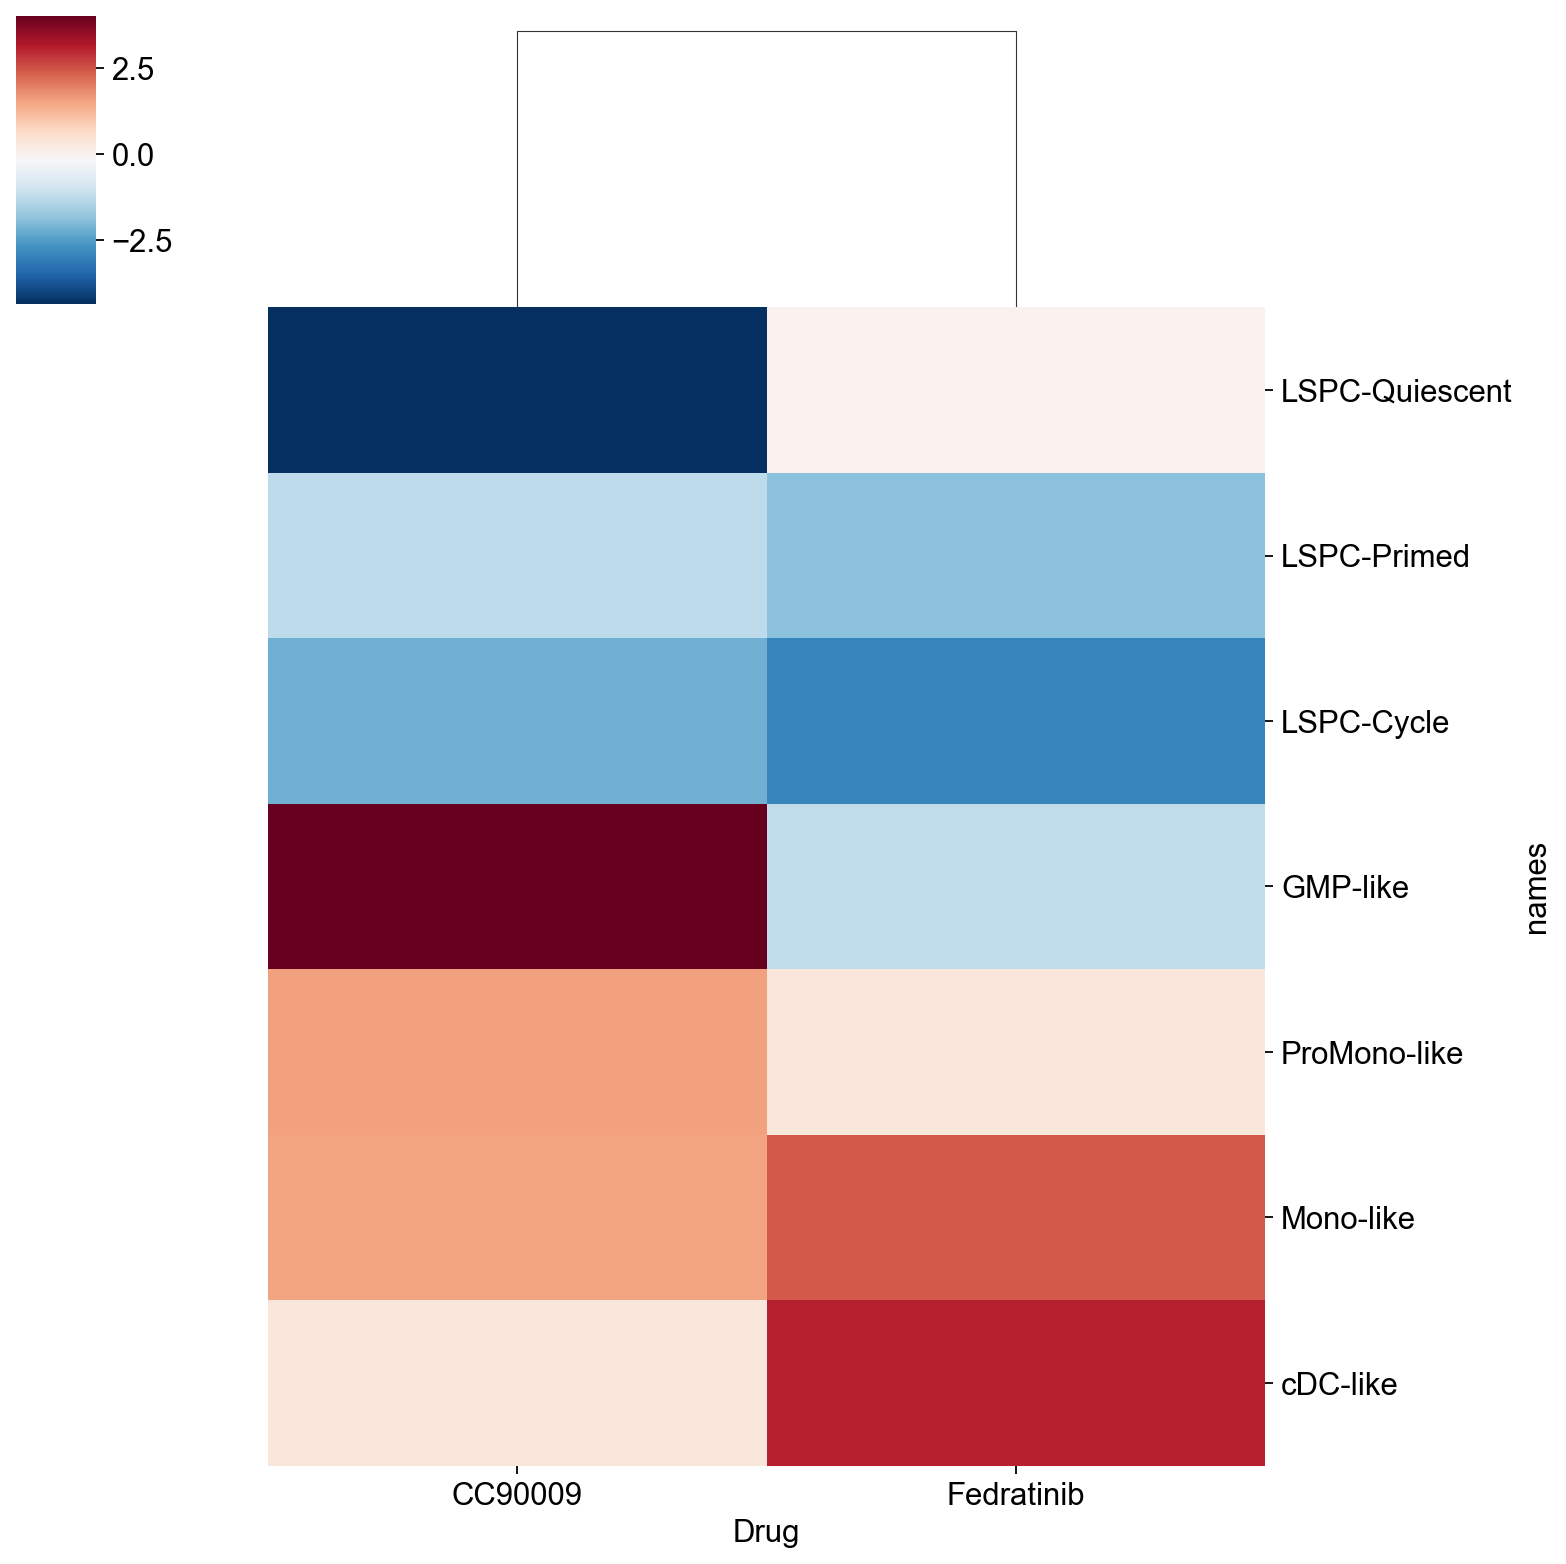

In [113]:
sns.clustermap(df.pivot(index='Drug', columns='names', values='logPval_dir')[['LSPC-Quiescent', 'LSPC-Primed', 'LSPC-Cycle', 'GMP-like', 'ProMono-like', 'Mono-like', 'cDC-like']].T, 
               col_cluster=True, row_cluster=False, cmap='RdBu_r', yticklabels=True)

In [114]:
df_logpval_dir = df.pivot(index='Drug', columns='names', values='logPval_dir')[['LSPC-Quiescent', 'LSPC-Primed', 'LSPC-Cycle', 'GMP-like', 'ProMono-like', 'Mono-like', 'cDC-like']].T
df_pvalue = df.pivot(index='Drug', columns='names', values='pvals')[['LSPC-Quiescent', 'LSPC-Primed', 'LSPC-Cycle', 'GMP-like', 'ProMono-like', 'Mono-like', 'cDC-like']].T

In [115]:
df_logpval_dir

Drug,CC90009,Fedratinib
names,,
LSPC-Quiescent,-4.338379,0.029053
LSPC-Primed,-1.271668,-1.876082
LSPC-Cycle,-2.180298,-2.914032
GMP-like,4.012658,-1.207422
ProMono-like,1.545621,0.312857
Mono-like,1.511669,2.409531
cDC-like,0.305368,3.081510


In [116]:
df_pvalue

Drug,CC90009,Fedratinib
names,,
LSPC-Quiescent,0.013058,0.971365
LSPC-Primed,0.280364,0.153189
LSPC-Cycle,0.113008,0.054257
GMP-like,0.018085,0.298967
ProMono-like,0.213180,0.731354
Mono-like,0.220542,0.089857
cDC-like,0.736852,0.045890


R[write to console]: corrplot 0.90 loaded



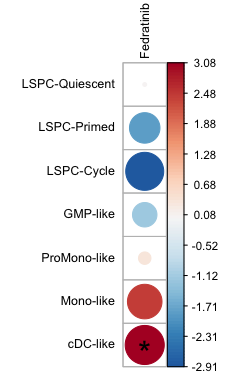

In [117]:
%%R -w 2.5 -h 3.75 --units in -r 100 -i df_logpval_dir -i df_pvalue

library("corrplot")
library(RColorBrewer)

colors <- colorRampPalette(rev(brewer.pal(9, 'RdBu')))
rdbu_continuous <- colors(100)

df_logpval_dir %>% select(Fedratinib) %>% data.matrix() %>% corrplot(method = "circle", tl.cex=0.75, p.mat = data.matrix(df_pvalue %>% select(Fedratinib)),
                                        sig.level=0.05, insig = "label_sig", pch.col = "black", pch.cex = 2, 
                                        is.corr = FALSE, tl.col = 'black', cl.ratio=1.3, cl.cex=0.7, col=rdbu_continuous) #c("pch", "p-value", "blank", "n", "label_sig"),) 

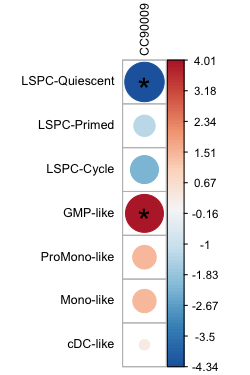

In [118]:
%%R -w 2.5 -h 3.75 --units in -r 100 -i df_logpval_dir -i df_pvalue

library("corrplot")
library(RColorBrewer)

df_logpval_dir %>% select(CC90009) %>% data.matrix() %>% corrplot(method = "circle", tl.cex=0.75, p.mat = data.matrix(df_pvalue %>% select(CC90009)),
                                        sig.level=0.05, insig = "label_sig", pch.col = "black", pch.cex = 2, 
                                        is.corr = FALSE, tl.col = 'black', cl.ratio=1.3, cl.cex=0.7, col=rdbu_continuous) #c("pch", "p-value", "blank", "n", "label_sig"),) 

## Compare Treatments

In [119]:
cat.obs['Fedratinib'] = np.where(cat.obs.Patient_ID == '100091', 'R', 
         np.where(cat.obs.Patient_ID == '90454', 'R', cat.obs.Fedratinib))

Trying to set attribute `.obs` of view, copying.


In [120]:
treated = cat[(cat.obs['Fedratinib'] != 'NA') | (cat.obs['CC90009'] != 'NA')  | (cat.obs['CC90009'] != 'NA')]

/Users/andyzeng/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2492: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [121]:
treated.obs['Combo'] = np.where(treated.obs.Patient==120846, 'NR/PR', np.where(treated.obs.Patient.isin([110500, 121020, 120791, 598, 120899, 90481, 130578]), 'R', 'NA'))
treated.obs['Fedratinib'] = np.where(treated.obs['Fedratinib'] == 'RR', 'R', treated.obs.Fedratinib)
treated.obs['CC90009'] = np.where(treated.obs['CC90009'] == 'RR', 'R', treated.obs.CC90009)

Trying to set attribute `.obs` of view, copying.


In [122]:
treated.obs['Double Treatment'] = np.where((treated.obs.Fedratinib=='NA') | (treated.obs.CC90009=='NA'), 'NA', 
        np.where((treated.obs.Fedratinib == 'R') & (treated.obs.CC90009 == 'R'), 'Double Responder',
                np.where((treated.obs.Fedratinib == 'R') & (treated.obs.CC90009 == 'NR/PR'), 'Fedratinib Only', 
                        np.where((treated.obs.Fedratinib == 'NR/PR') & (treated.obs.CC90009 == 'R'), 'CC90009 Only', 
                                np.where((treated.obs.Fedratinib == 'NR/PR') & (treated.obs.CC90009 == 'NR/PR'), 'No Response', 'NA')))))

In [123]:
cat.obs

,B-Absolute,CTL-Absolute,GMP-like-Absolute,LSPC-Cycle-Absolute,LSPC-Primed-Absolute,LSPC-Quiescent-Absolute,Mono-like-Absolute,Monocyte-Absolute,NK-Absolute,Plasma-Absolute,...,RF_CC90009,RF_Vehicle,RF_Pvalue,CC90009 RF Reduction,BM_CC90009,BM_Vehicle,BM_Pvalue,CC90009 BM Reduction,CC90009 Response,CC90009
Sample,,,,,,,,,,,,,,,,,,,,,
LSC0001_Bl_Bulk,0.129641,0.084778,7.494859,1.268523,0.000000,2.097598,0.000000,0.542465,0.415327,0.175965,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NA
LSC0004_Bl_Bulk,0.312419,0.000000,4.035892,0.000000,1.110485,4.727725,0.000000,0.511934,0.938947,0.392959,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NA
LSC0005_Bl_Bulk,0.701088,0.000000,0.356658,2.094053,0.095986,1.456185,8.019021,6.403949,0.778016,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NA
LSC0006_Bl_Bulk,0.236957,0.089242,3.020904,5.423254,0.000000,5.118757,3.507483,6.339745,0.453806,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NA
LSC0007_Bl_Bulk,1.383769,0.000000,0.204460,2.805789,0.847735,4.723894,5.935950,7.575315,0.455585,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CC31,0.217739,0.059943,0.979434,1.206571,6.414339,5.041229,0.000000,0.939143,0.222738,0.380299,...,0.01,2.47,0.160000,99.60,0.00,0.02,0.090000,100.00,too low,NA
CC32,0.635993,0.021322,9.214156,2.891359,0.690487,7.319177,1.118422,1.559950,1.302541,0.437364,...,2.62,54.52,0.020000,95.19,0.61,45.52,0.000003,98.66,R,R
CC33,0.626360,0.168095,12.135420,0.000000,2.792510,3.397467,2.194392,1.470818,1.310799,0.626633,...,3.20,81.77,0.000037,96.09,1.37,81.91,0.000012,98.33,R,R


... storing 'CIRM_ID' as categorical
... storing 'Patient_ID' as categorical
... storing 'SampleType' as categorical
... storing 'Treatment' as categorical
... storing 'Response' as categorical
... storing 'Processing' as categorical
... storing 'STAT5' as categorical
... storing 'SRC' as categorical
... storing 'Mouse' as categorical
... storing 'Subtype' as categorical
... storing 'Fed Response' as categorical
... storing 'Fedratinib' as categorical
... storing 'LSC17_cat' as categorical
... storing 'CC90009 Response' as categorical
... storing 'CC90009' as categorical
... storing 'Combo' as categorical
... storing 'Double Treatment' as categorical
... storing 'Cluster' as categorical


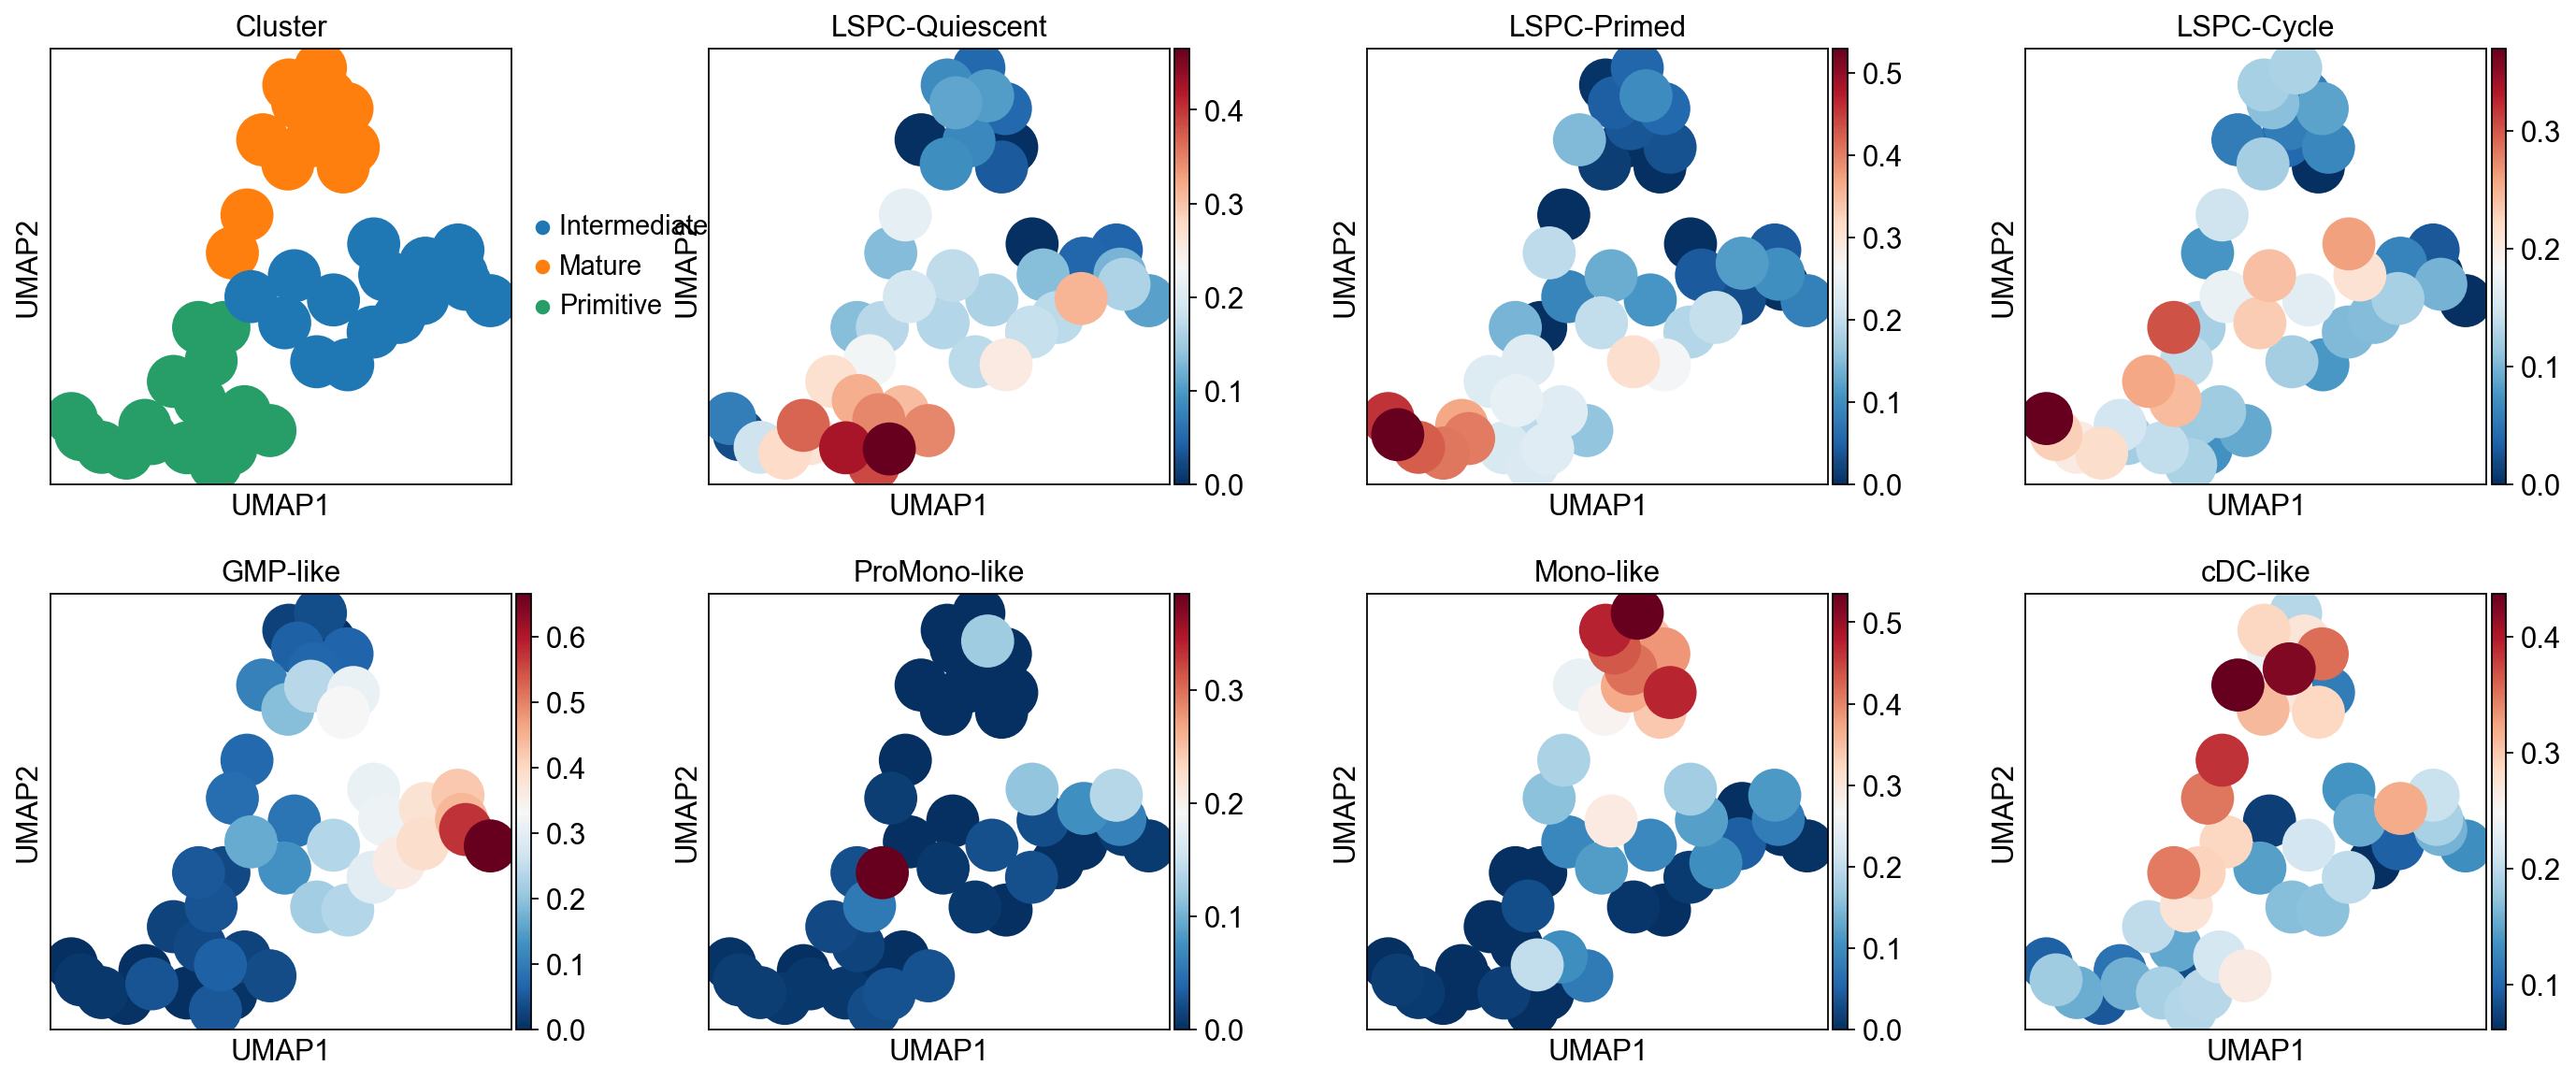

In [124]:
sc.pp.pca(treated)
sc.pp.neighbors(treated, n_neighbors=15)
sc.tl.umap(treated, min_dist=0.1)
sc.tl.leiden(treated, resolution=0.7)
umap1 = treated.obsm['X_umap'][:,0].copy()
umap2 = treated.obsm['X_umap'][:,1].copy()
treated.obsm['X_umap'][:,0] = -umap2
treated.obsm['X_umap'][:,1] = -umap1
treated.obs['Cluster'] = np.where(treated.obs['leiden']=='0', 'Primitive', np.where(treated.obs['leiden']=='2', 'Mature', 'Intermediate / GMP'))
sc.pl.umap(treated, color=['Cluster', 'LSPC-Quiescent', 'LSPC-Primed', 'LSPC-Cycle', 'GMP-like', 'ProMono-like', 'Mono-like', 'cDC-like'], ncols=4, cmap='RdBu_r', wspace=0.3)

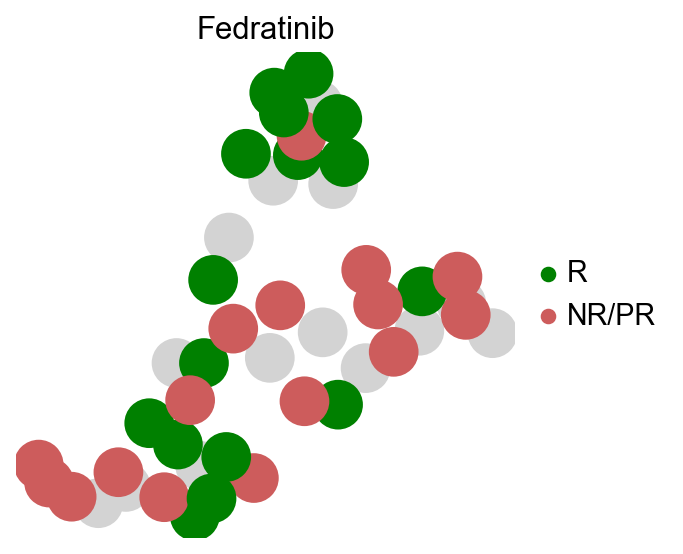

In [125]:
sc.pl.umap(treated, color=['Fedratinib'], groups = ['R', 'NR/PR'], palette=['Green', 'IndianRed'], size=2000, frameon=False)

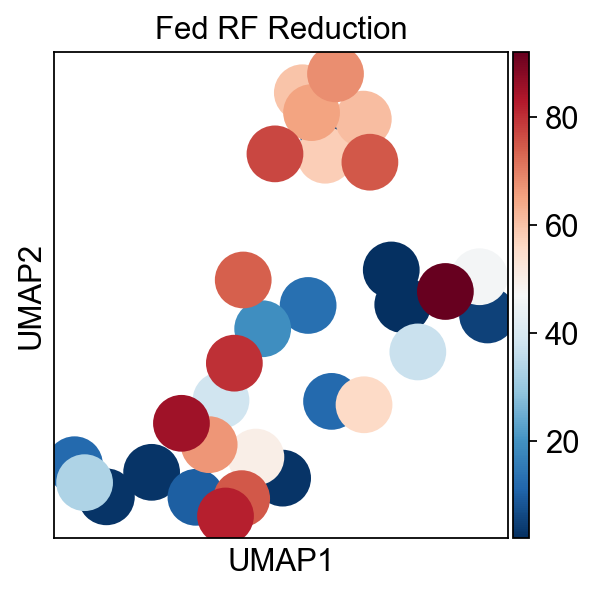

In [126]:
sc.pl.umap(treated, color=['Fed RF Reduction'], cmap='RdBu_r')

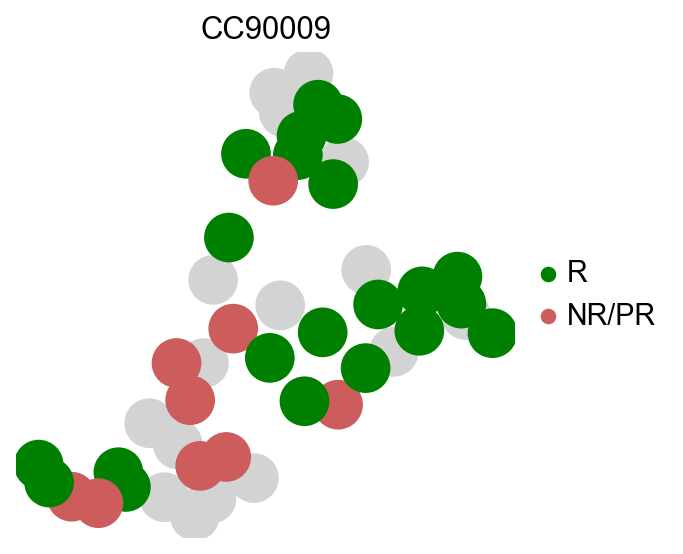

In [127]:
sc.pl.umap(treated, color=['CC90009'], groups = ['R', 'NR/PR'], palette=['Green', 'IndianRed'], size=2000, frameon=False)

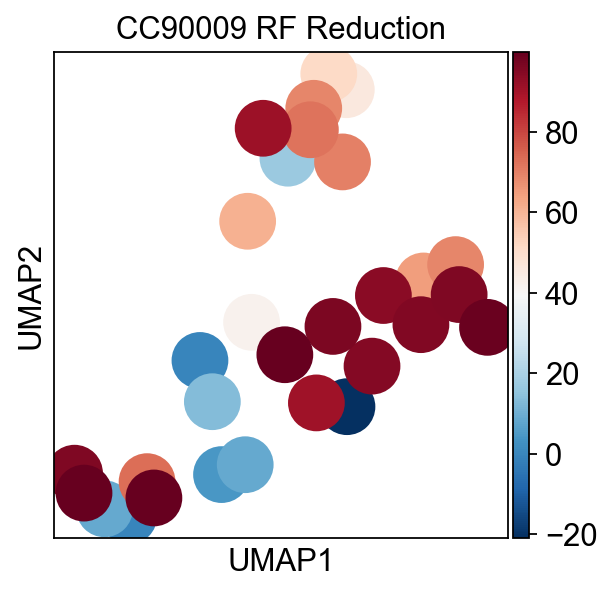

In [128]:
sc.pl.umap(treated, color=['CC90009 RF Reduction'], cmap='RdBu_r')

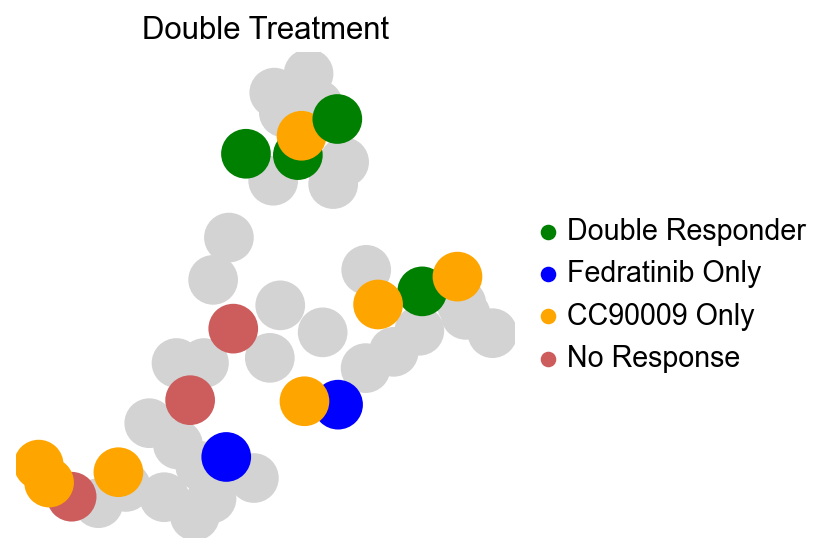

In [129]:
sc.pl.umap(treated, color=['Double Treatment'], groups = ['Double Responder', 'Fedratinib Only', 'CC90009 Only', 'No Response'], 
           palette=['Orange', 'Green', 'Blue', 'Grey', 'IndianRed'], size=2000, frameon=False)

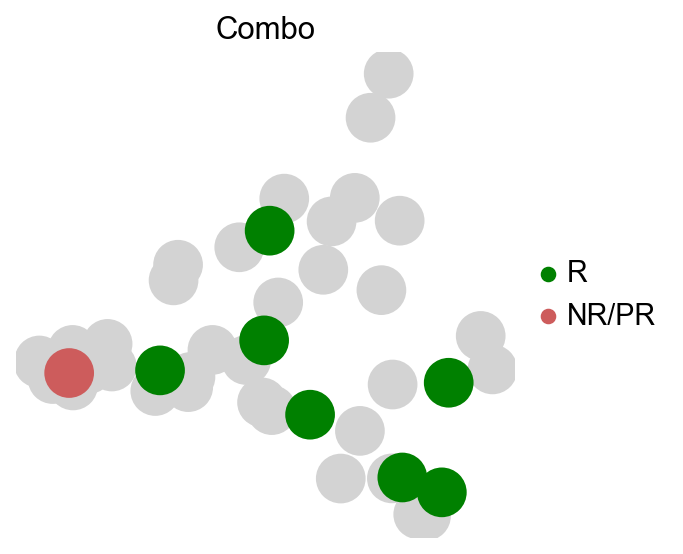

In [130]:
sc.pl.pca(treated, color=['Combo'], groups = ['R', 'NR/PR'], palette=['Green', 'IndianRed'], size=2000, frameon=False)

In [131]:
tk.get_obs_prop(treated[treated.obs['Fedratinib']!='NA'], 'Cluster', 'Fedratinib', prop=False).loc[['R', 'NR/PR']].style.background_gradient(cmap='RdBu_r')

/Users/andyzeng/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2492: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Cluster,Intermediate / GMP,Mature,Primitive
Fedratinib,,,
R,2,8,6
NR/PR,8,1,7


In [132]:
tk.get_obs_prop(treated[treated.obs['CC90009']!='NA'], 'Cluster', 'CC90009', prop=False).loc[['R', 'NR/PR']].style.background_gradient(cmap='RdBu_r')

Cluster,Intermediate / GMP,Mature,Primitive
CC90009,,,
R,10,7,4
NR/PR,2,1,6


In [133]:
results = treated.obs[['Patient', 'CC90009 Response', 'Fed Response', 'Cluster', 'CC90009 RF Reduction', 'Fed RF Reduction', 'PC1', 'PC2', 
                      'LSPC-Quiescent-Relative', 'LSPC-Primed-Relative', 'LSPC-Cycle-Relative', 'GMP-like-Relative', 'ProMono-like-Relative', 'Mono-like-Relative', 'cDC-like-Relative']].reset_index()

KeyError: "['PC2', 'PC1'] not in index"

In [ ]:
results['Fed Response'] = np.where(results['Fed Response'] == 'R', 'Responder', 
         np.where(results['Fed Response'] == 'PR', 'Partial Responder', 
                  np.where(results['Fed Response'] == 'NR', 'Non-Responder', 'NA')))

results['CC90009 Response'] = np.where(results['CC90009 Response'] == 'R', 'Responder', 
         np.where(results['CC90009 Response'] == 'PR', 'Partial Responder', 
                  np.where(results['CC90009 Response'] == 'NR', 'Non-Responder', 'NA')))

### Combined Plots

In [ ]:
%%R -i results -h 6.5 -w 15 --units in

hierarchy_colors = c('#A7303099', '#CD534C99', '#8F770099', '#3B3B3B99', '#0073C299', '#003C6799', '#EFC00099')

CC90009_populations <- results %>% 
    mutate(Patient = Patient %>% as.character()) %>%
    filter(`CC90009 Response` != 'NA') %>%
    mutate(Patient = factor(Patient, levels = arrange(., -`CC90009 RF Reduction`)$Patient)) %>% 
    mutate(Cluster = factor(Cluster, levels = c('Primitive', 'Intermediate / GMP', 'Mature'))) %>% 
    gather(-Patient, -Sample, -`CC90009 Response`, -`Fed Response`, -Cluster, -`CC90009 RF Reduction`, -`Fed RF Reduction`, -PC1, -PC2, key='Population', value='prop') %>% 
    mutate(Population = Population %>% str_replace('-Relative', ''), 
           Population = factor(Population, levels = c("LSPC-Quiescent", "LSPC-Primed", "LSPC-Cycle", 
                                                    "GMP-like", "ProMono-like", "Mono-like", "cDC-like")))
    
p1 <- CC90009_populations %>% 
   ggplot(aes(x=Patient, y=prop, fill=Population)) +
       geom_col() + 
       scale_fill_manual(values = hierarchy_colors) + 
       ylab("Cell Type Abundance") + labs(fill='Population\n(pre-treatment)') +
       theme_pubr() +
       scale_y_continuous(expand = c(0, 0), limits = c(0, 1.01)) +
       facet_grid(.~Cluster, scales="free_x", space = "free_x") + 
        theme(legend.position = "right", legend.text = element_text(size=11),
              axis.title.x = element_blank(), axis.ticks = element_blank(), axis.text.x = element_text(angle = 90, size=10, vjust = 0.5, hjust=1), 
            strip.text.x = element_text(size = 12), axis.line.x = element_line(colour = 'black', size = 0.1), axis.line.y = element_blank()) +
        theme(strip.text.x = element_blank() , 
          strip.background = element_blank(),
          plot.margin = unit( c(0.75, 0.35, 0.5, 0.75) , units = "lines"))

CC90009 <- results %>% 
    mutate(Patient = Patient %>% as.character()) %>%
    filter(`CC90009 Response` != 'NA') %>%
    mutate(Patient = factor(Patient, levels = arrange(., -`CC90009 RF Reduction`)$Patient)) %>% 
    mutate(Cluster = factor(Cluster, levels = c('Primitive', 'Intermediate / GMP', 'Mature'))) %>% 
    mutate(`CC90009 Response` = factor(`CC90009 Response`, levels = c('Responder', 'Partial Responder', 'Non-Responder')))
    
p2 <- CC90009 %>%
    ggplot(aes(y=-`CC90009 RF Reduction`, x=Patient, fill=`CC90009 Response`)) +
    geom_col() + ylab('Change in Engraftment (RF)') +
    scale_y_continuous(limits = c(-100, 21), breaks=c(-100, -80, -60, -40, -20, 0, 20)) + 
    facet_grid(.~Cluster, scales="free_x", space = "free_x") +
    #scale_fill_manual(values = c('green', 'blue', 'red')) + 
#    geom_errorbar(aes(ymin=len-sd, ymax=len+sd), width=.2,
#                 position=position_dodge(.9)) +
    scale_fill_manual(values=c('#20854EFF', '#E18727FF', '#BC3C29FF')) +#  #0072B5FF
    geom_hline(yintercept = 0, linetype=1, color='darkgrey') +
    theme_pubr() + 
    labs(fill='CC90009\nResponse') +
    theme(legend.position = "right", legend.text = element_text(size=11),
          axis.title.x = element_blank(), axis.ticks = element_blank(), axis.text.x = element_text(angle = 90, size=10, vjust = 0.5, hjust=1), 
          strip.text.x = element_text(size = 13), axis.line.x = element_line(colour = 'black', size = 0.4)) #+
    #theme(plot.margin= unit( c(0.2, 2.0, 0.2, 0.5) , units = "lines" ))
    
ggarrange(p2, p1, ncol=1, nrow=2, heights=c(1, 0.75))# + ggsave("Figures/TCGAnew_bars_Clusters.png", height = 5, width = 11.5, dpi = 'retina')

In [ ]:
%%R -i results -h 6.5 -w 15 --units in

hierarchy_colors = c('#A7303099', '#CD534C99', '#8F770099', '#3B3B3B99', '#0073C299', '#003C6799', '#EFC00099')

Fed_populations <- results %>% 
    mutate(Patient = Patient %>% as.character()) %>%
    filter(`Fed Response` != 'NA') %>%
    mutate(Patient = factor(Patient, levels = arrange(., -`Fed RF Reduction`)$Patient)) %>% 
    mutate(Cluster = factor(Cluster, levels = c('Primitive', 'Intermediate / GMP', 'Mature'))) %>% 
    gather(-Patient, -Sample, -`CC90009 Response`, -`Fed Response`, -Cluster, -`CC90009 RF Reduction`, -`Fed RF Reduction`, -PC1, -PC2, key='Population', value='prop') %>% 
    mutate(Population = Population %>% str_replace('-Relative', ''), 
           Population = factor(Population, levels = c("LSPC-Quiescent", "LSPC-Primed", "LSPC-Cycle", 
                                                    "GMP-like", "ProMono-like", "Mono-like", "cDC-like")))
    
p1 <- Fed_populations %>% 
   ggplot(aes(x=Patient, y=prop, fill=Population)) +
       geom_col() + 
       scale_fill_manual(values = hierarchy_colors) + 
       ylab("Cell Type Abundance") + labs(fill='Population\n(pre-treatment)') +
       theme_pubr() +
       scale_y_continuous(expand = c(0, 0), limits = c(0, 1.01)) +
       facet_grid(.~Cluster, scales="free_x", space = "free_x") + 
        theme(legend.position = "right", legend.text = element_text(size=11),
              axis.title.x = element_blank(), axis.ticks = element_blank(), axis.text.x = element_text(angle=90, size=10, vjust = 0.5, hjust=1),
            strip.text.x = element_text(size = 12), axis.line.x = element_line(colour = 'black', size = 0.1), axis.line.y = element_blank()) +
        theme(strip.text.x = element_blank(), 
          strip.background = element_blank(),
          plot.margin = unit( c(0.75, 0.35, 0.5, 0.75) , units = "lines"))


Fedratinib <- results %>% 
    mutate(Patient = Patient %>% as.character()) %>%
    filter(`Fed Response` != 'NA') %>%
    mutate(Patient = factor(Patient, levels = arrange(., -`Fed RF Reduction`)$Patient)) %>% 
    mutate(Cluster = factor(Cluster, levels = c('Primitive', 'Intermediate / GMP', 'Mature'))) %>% 
    mutate(`Fed Response` = factor(`Fed Response`, levels = c('Responder', 'Partial Responder', 'Non-Responder')))
    
p2 <- Fedratinib %>%
    ggplot(aes(y=-`Fed RF Reduction`, x=Patient, fill=`Fed Response`)) +
    geom_col() + ylab('Change in Engraftment (RF)') +
    scale_y_continuous(limits = c(-100, 21), breaks=c(-100, -80, -60, -40, -20, 0, 20)) + 
    facet_grid(.~Cluster, scales="free_x", space = "free_x") +
    #scale_fill_manual(values = c('green', 'blue', 'red')) + 
#    geom_errorbar(aes(ymin=len-sd, ymax=len+sd), width=.2,
#                 position=position_dodge(.9)) +
    scale_fill_manual(values=c('#20854EFF', '#E18727FF', '#BC3C29FF')) +#  #0072B5FF
    geom_hline(yintercept = 0, linetype=1, color='darkgrey') +
    theme_pubr() + 
    labs(fill='Fedratinib\nResponse') +
    theme(legend.position = "right", legend.text = element_text(size=11),
          axis.title.x = element_blank(), axis.ticks = element_blank(), axis.text.x = element_text(angle=90, size=10, vjust = 0.5, hjust=1),#axis.text.x = element_blank(),#element_text(angle = 90, vjust = 0.5, hjust=1), 
          strip.text.x = element_text(size = 13), axis.line.x = element_line(colour = 'black', size = 0.4)) #+ 
#    theme(plot.margin= unit( c(0.2, 2.0, 0.2, 0.5) , units = "lines" ))
    
ggarrange(p2, p1, ncol=1, nrow=2, heights=c(1, 0.75))# + ggsave("Figures/TCGAnew_bars_Clusters.png", height = 5, width = 11.5, dpi = 'retina')

## Genomic

In [ ]:
clinical = pd.read_csv("Data/Fig6_AML_PDX_Response/JAK2_CC90009_Clinical.csv")#.set_index('Patient')
clinical.Patient = clinical.Patient.astype('float')
clinical

In [134]:
%%R -i clinical -h 1.5 -w 15 --units in

clinical %>% 
    select(Patient, NPM1, `FLT3-ITD`, Hierarchy) %>% 
    mutate(Patient = Patient %>% as.character()) %>%
    gather(-Patient, -Hierarchy, key='var', value='Mutation') %>% 
    mutate(Mutation = ifelse(Mutation == 'positive', 'Positive', 
                            ifelse(Mutation == 'negative', 'Negative', 'NA'))) %>% 
    ggplot(aes(var, Patient, fill=Mutation)) +
    geom_tile() + 
    coord_flip() +
    facet_wrap(.~Hierarchy, scales='free_x') +
    scale_fill_manual(values=c("grey90", "grey40", "blue4")) +
    theme(legend.position = "right", axis.title.x = element_blank(), axis.ticks = element_blank(), axis.text.x = element_text(angle=90, size=10),
            strip.text.x = element_blank(), axis.line.x = element_line(colour = 'black', size = 0.1), axis.line.y = element_blank())

NameError: name 'clinical' is not defined

In [135]:
%%R -i results -h 7 -w 15 --units in

hierarchy_colors = c('#A7303099', '#CD534C99', '#8F770099', '#3B3B3B99', '#0073C299', '#003C6799', '#EFC00099')

Fed_populations <- results %>% 
    mutate(Patient = Patient %>% as.character()) %>%
    filter(`Fed Response` != 'NA') %>%
    mutate(Patient = factor(Patient, levels = arrange(., -`Fed RF Reduction`)$Patient)) %>% 
    mutate(Cluster = factor(Cluster, levels = c('Primitive', 'Intermediate / GMP', 'Mature'))) %>% 
    gather(-Patient, -Sample, -`CC90009 Response`, -`Fed Response`, -Cluster, -`CC90009 RF Reduction`, -`Fed RF Reduction`, -PC1, -PC2, key='Population', value='prop') %>% 
    mutate(Population = Population %>% str_replace('-Relative', ''), 
           Population = factor(Population, levels = c("LSPC-Quiescent", "LSPC-Primed", "LSPC-Cycle", 
                                                    "GMP-like", "ProMono-like", "Mono-like", "cDC-like")))
    
p1 <- Fed_populations %>% 
   ggplot(aes(x=Patient, y=prop, fill=Population)) +
       geom_col() + 
       scale_fill_manual(values = hierarchy_colors) + 
       ylab("Cell Type Abundance") + labs(fill='Population') +
       theme_pubr() +
       scale_y_continuous(expand = c(0, 0), limits = c(0, 1.01)) +
       facet_grid(.~Cluster, scales="free_x", space = "free_x") + 
        theme(legend.position = "right", legend.text = element_text(size=11),
              axis.title.x = element_blank(), axis.ticks = element_blank(), axis.text.x = element_text(angle=90, size=10, vjust = 0.5, hjust=1),
            strip.text.x = element_text(size = 12), axis.line.x = element_line(colour = 'black', size = 0.1), axis.line.y = element_blank()) +
        theme(strip.text.x = element_blank(), 
          strip.background = element_blank(),
          plot.margin = unit( c(0.75, 0.4, 0.5, 0.75) , units = "lines"))


Fedratinib <- results %>% 
    mutate(Patient = Patient %>% as.character()) %>%
    filter(`Fed Response` != 'NA') %>%
    mutate(Patient = factor(Patient, levels = arrange(., -`Fed RF Reduction`)$Patient)) %>% 
    mutate(Cluster = factor(Cluster, levels = c('Primitive', 'Intermediate / GMP', 'Mature'))) %>% 
    mutate(`Fed Response` = factor(`Fed Response`, levels = c('Responder', 'Partial Responder', 'Non-Responder')))
    
p2 <- Fedratinib %>%
    ggplot(aes(y=-`Fed RF Reduction`, x=Patient, fill=`Fed Response`)) +
    geom_col() + ylab('Change in Engraftment (RF)') +
    scale_y_continuous(limits = c(-100, 21), breaks=c(-100, -80, -60, -40, -20, 0, 20)) + 
    facet_grid(.~Cluster, scales="free_x", space = "free_x") +
    #scale_fill_manual(values = c('green', 'blue', 'red')) + 
#    geom_errorbar(aes(ymin=len-sd, ymax=len+sd), width=.2,
#                 position=position_dodge(.9)) +
    scale_fill_manual(values=c('#20854EFF', '#E18727FF', '#BC3C29FF')) +#  #0072B5FF
    geom_hline(yintercept = 0, linetype=1, color='darkgrey') +
    theme_pubr() + 
    labs(fill='Fedratinib\nResponse') +
    theme(legend.position = "right", legend.text = element_text(size=11),
          axis.title.x = element_blank(), axis.ticks = element_blank(), axis.text.x = element_text(angle=90, size=10, vjust = 0.5, hjust=1),#axis.text.x = element_blank(),#element_text(angle = 90, vjust = 0.5, hjust=1), 
          strip.text.x = element_text(size = 13), axis.line.x = element_line(colour = 'black', size = 0.4)) #+ 
#    theme(plot.margin= unit( c(0.2, 2.0, 0.2, 0.5) , units = "lines" ))


Fed_mutation <- results %>% 
    left_join(clinical) %>% 
    filter(`Fed Response` != 'NA') %>% 
    select(Patient, Cluster, `Fed RF Reduction`, NPM1, `FLT3-ITD`) %>% 
    mutate(Cluster = factor(Cluster, levels = c('Primitive', 'Intermediate / GMP', 'Mature'))) %>% 
    mutate(NPM1 = ifelse(NPM1 == 'positive', 'Positive', 
                         ifelse(NPM1 == 'negative', 'Negative', NA))) %>%
    mutate(`FLT3-ITD` = ifelse(`FLT3-ITD` == 'positive', 'Positive', 
                         ifelse(`FLT3-ITD` == 'negative', 'Negative', NA))) %>%
    unique()
    
mut <- Fed_mutation %>% 
    filter(!((Patient == '90240') & (NPM1 == 'NA'))) %>% 
    mutate(Patient = Patient %>% as.character()) %>% 
    mutate(Patient = factor(Patient, levels = arrange(., -`Fed RF Reduction`)$Patient)) %>% 
    select(-`Fed RF Reduction`) %>%
    gather(-Patient, -Cluster, key='var', value='Mutation') %>%
    mutate(Mutation = factor(Mutation, levels=c('Positive', 'Negative'))) %>%
    ggplot(aes(var, Patient, fill=Mutation)) +
    geom_tile(colour = "black", size = 0.2) + 
    coord_flip() +
    theme_pubr(legend='right') +
    facet_grid(.~Cluster, scales='free_x', space = "free_x") +
    scale_fill_manual(values=c("royalblue4", "grey70"), na.translate=T) +
    theme(axis.title.x = element_blank(), axis.ticks = element_blank(), axis.text.x = element_blank(), axis.text.y = element_text(size=10.5),
          strip.text.x = element_blank(), axis.line.x = element_blank(), axis.line.y = element_blank(), axis.title.y = element_blank(),
         plot.margin = unit( c(0.7, 3.65, 0, 0.1), units = "lines"), panel.spacing = unit(0.6, "lines"))
    
ggarrange(p2, mut, p1, ncol=1, nrow=3, heights=c(0.75, 0.14, 0.65))# + ggsave("Figures/Fedratinib_Response_Geno_Hierarchy.png", height = 7, width = 15, dpi = 'retina')

NameError: name 'results' is not defined

In [136]:
%%R -i results -i clinical -h 7 -w 14.7 --units in

cc90009 = read_csv('Data/Fig6_AML_PDX_Response/CC90009_ID_Conversion.csv') %>% 
    rename('Patient'='PMH_ID') %>% 
    mutate(Surka_ID = Surka_ID %>% str_replace("AML",''))


hierarchy_colors = c('#A7303099', '#CD534C99', '#8F770099', '#3B3B3B99', '#0073C299', '#003C6799', '#EFC00099')

CC90009_populations <- results %>% 
    left_join(cc90009) %>%
    mutate(Patient = Surka_ID %>% as.character()) %>%
    filter(`CC90009 Response` != 'NA') %>%
    mutate(Patient = factor(Patient, levels = arrange(., -`CC90009 RF Reduction`)$Patient)) %>% 
    mutate(Cluster = factor(Cluster, levels = c('Primitive', 'Intermediate / GMP', 'Mature'))) %>% 
    gather(-Surka_ID, -Patient, -Sample, -`CC90009 Response`, -`Fed Response`, -Cluster, -`CC90009 RF Reduction`, -`Fed RF Reduction`, -PC1, -PC2, key='Population', value='prop') %>% 
    mutate(Population = Population %>% str_replace('-Relative', ''), 
           Population = factor(Population, levels = c("LSPC-Quiescent", "LSPC-Primed", "LSPC-Cycle", 
                                                    "GMP-like", "ProMono-like", "Mono-like", "cDC-like")))
    
p1 <- CC90009_populations %>% 
   ggplot(aes(x=Surka_ID, y=prop, fill=Population)) +
       geom_col() + 
       scale_fill_manual(values = hierarchy_colors) + 
       ylab("Cell Type Abundance") + labs(fill='Population') +
       theme_pubr() +
       scale_y_continuous(expand = c(0, 0), limits = c(0, 1.01)) +
       facet_grid(.~Cluster, scales="free_x", space = "free_x") + 
        theme(legend.position = "right", legend.text = element_text(size=11),
              axis.title.x = element_blank(), axis.ticks = element_blank(), axis.text.x = element_text(angle = 0, size=13, vjust = -1),#, hjust=1), 
            strip.text.x = element_text(size = 12), axis.line.x = element_line(colour = 'black', size = 0.1), axis.line.y = element_blank()) +
        theme(strip.text.x = element_blank() , 
          strip.background = element_blank(),
          plot.margin = unit( c(0.75, 0.4, 1.5, 0.75) , units = "lines"))

CC90009 <- results %>% 
    left_join(cc90009) %>% 
    mutate(Patient = Surka_ID %>% as.character()) %>%
    filter(`CC90009 Response` != 'NA') %>%
    mutate(Patient = factor(Patient, levels = arrange(., -`CC90009 RF Reduction`)$Patient)) %>% 
    mutate(Cluster = factor(Cluster, levels = c('Primitive', 'Intermediate / GMP', 'Mature'))) %>% 
    mutate(`CC90009 Response` = factor(`CC90009 Response`, levels = c('Responder', 'Partial Responder', 'Non-Responder')))
    
p2 <- CC90009 %>%
    ggplot(aes(y=-`CC90009 RF Reduction`, x=Patient, fill=`CC90009 Response`)) +
    geom_col() + ylab('Change in Engraftment (RF)') +
    scale_y_continuous(limits = c(-100, 21), breaks=c(-100, -80, -60, -40, -20, 0, 20)) + 
    facet_grid(.~Cluster, scales="free_x", space = "free_x") +
    #scale_fill_manual(values = c('green', 'blue', 'red')) + 
#    geom_errorbar(aes(ymin=len-sd, ymax=len+sd), width=.2,
#                 position=position_dodge(.9)) +
    scale_fill_manual(values=c('#20854EFF', '#E18727FF', '#BC3C29FF')) +#  #0072B5FF
    geom_hline(yintercept = 0, linetype=1, color='darkgrey') +
    theme_pubr() + 
    labs(fill='CC90009\nResponse') +
    theme(legend.position = "right", legend.text = element_text(size=11),
          axis.title.x = element_blank(), axis.ticks = element_blank(), axis.text.x = element_text(angle = 0, size=13, vjust=-1),#, vjust = 0.5, hjust=1), 
          strip.text.x = element_text(size = 13), axis.line.x = element_line(colour = 'black', size = 0.4)) #+
    #theme(plot.margin= unit( c(0.2, 2.0, 0.2, 0.5) , units = "lines" ))
    

CC_mutation <- results %>% 
    left_join(clinical) %>% 
    left_join(cc90009) %>% 
    mutate(Patient = Surka_ID %>% as.character()) %>%
    filter(`CC90009 Response` != 'NA') %>% 
    select(Patient, Cluster, `CC90009 RF Reduction`, NPM1, `FLT3-ITD`) %>% 
    mutate(Cluster = factor(Cluster, levels = c('Primitive', 'Intermediate / GMP', 'Mature'))) %>% 
    mutate(NPM1 = ifelse(NPM1 == 'positive', 'Positive', 
                         ifelse(NPM1 == 'negative', 'Negative', NA))) %>%
    mutate(`FLT3-ITD` = ifelse(`FLT3-ITD` == 'positive', 'Positive', 
                         ifelse(`FLT3-ITD` == 'negative', 'Negative', NA))) %>%
    unique()
    
mut <- CC_mutation %>% 
    filter(!((Patient == '90240') & (NPM1 == 'NA'))) %>% 
    mutate(Patient = Patient %>% as.character()) %>% 
    mutate(Patient = factor(Patient, levels = arrange(., -`CC90009 RF Reduction`)$Patient)) %>% 
    select(-`CC90009 RF Reduction`) %>%
    gather(-Patient, -Cluster, key='var', value='Mutation') %>%
    mutate(Mutation = factor(Mutation, levels=c('Positive', 'Negative'))) %>%
    ggplot(aes(var, Patient, fill=Mutation)) +
    geom_tile(colour = "black", size = 0.2) + 
    coord_flip() +
    theme_pubr(legend='right') +
    facet_grid(.~Cluster, scales='free_x', space = "free_x") +
    scale_fill_manual(values=c("royalblue4", "grey70"), na.translate=T) +
    theme(axis.title.x = element_blank(), axis.ticks = element_blank(), axis.text.x = element_blank(), axis.text.y = element_text(size=10.5),
          strip.text.x = element_blank(), axis.line.x = element_blank(), axis.line.y = element_blank(), axis.title.y = element_blank(),
         plot.margin = unit( c(1.5, 3.65, 0, 0.09) , units = "lines"), panel.spacing = unit(0.6, "lines"))
    
ggarrange(p2, mut, p1, ncol=1, nrow=3, heights=c(0.7, 0.2, 0.65)) #+ ggsave("Figures/CC90009_Response_Geno_Hierarchy.png", height = 7, width = 14.7, dpi = 'retina')

NameError: name 'results' is not defined

# Combo

In [137]:
%%R
library(ggsci)

dat <- read_csv('Data/Fig6_AML_PDX_Response/Combo_CC90009_Fed_treatment_engraftment.csv') %>% 
    mutate(Treatment = factor(Treatment, levels=c("Control", "Fedratinib", "CC90009", "Combo"))) %>%
    mutate(Patient = Patient %>% as.character() %>% factor(levels = c("120846", "120899", "121020", "90481", "130578", "598", "120791", "110500")))


── Column specification ────────────────────────────────────────────────────────
cols(
  Patient = col_double(),
  RF = col_double(),
  BM = col_double(),
  Treatment = col_character()
)



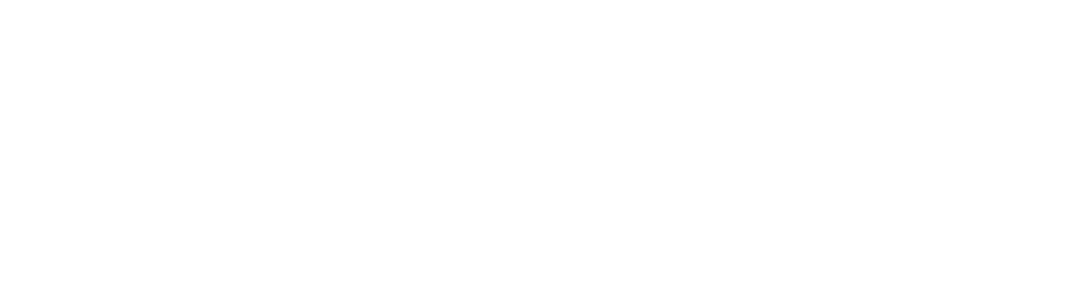

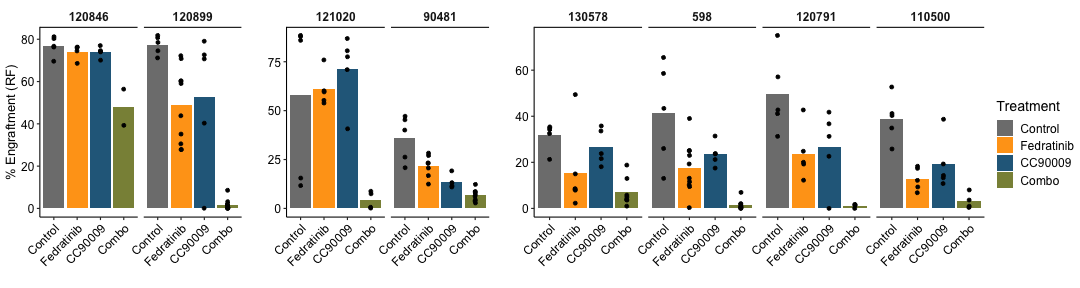

In [138]:
%%R -h 4 -w 15 --units in

primitive = dat %>% 
    filter(Patient %in% c("120846", "120899")) %>%
    ggplot(aes(x = Treatment, y = RF)) +
    geom_bar(aes(fill = Treatment), stat = 'summary', fun='mean') +
    geom_jitter(width=0.01) + 
    theme_pubr() + 
    ylab('% Engraftment (RF)') + xlab('')+
    #ylim(c(0, 90)) +
    scale_fill_manual(values=c("#767676F2", "#FFA319FF", "#155F83F2", "#8A9045FF", "#350E20E5", "#800000E5",  "#616530E5")) +
    facet_wrap(.~Patient) + 
    theme(axis.text.x=element_text(angle=45, hjust=1), axis.title.y=element_text(size=13), strip.text.x=element_text(size=12, face='bold'), strip.background = element_blank()) + 
    theme(legend.position='right', legend.text = element_text(size=12), legend.title = element_text(size=14)) + 
    annotate("segment",x=Inf,xend=-Inf,y=Inf,yend=Inf,color="black",lwd=1)
    
intgmp = dat %>% 
    filter(Patient %in% c("121020", "90481")) %>%
    ggplot(aes(x = Treatment, y = RF)) +
    geom_bar(aes(fill = Treatment), stat = 'summary', fun='mean') +
    geom_jitter(width=0.01) + 
    theme_pubr() + 
    ylab('') + xlab('')+
    #ylim(c(0, 90)) +
    #scale_fill_uchicago(palette='dark', alpha=0.8) +
    scale_fill_manual(values=c("#767676F2", "#FFA319FF", "#155F83F2", "#8A9045FF", "#350E20E5", "#800000E5",  "#616530E5")) +
    facet_wrap(.~Patient) + 
    theme(axis.text.x=element_text(angle=45, hjust=1), strip.text.x=element_text(size=12, face='bold'), strip.background = element_blank()) + 
    theme(legend.position='right', legend.text = element_text(size=12), legend.title = element_text(size=14)) + 
    annotate("segment",x=Inf,xend=-Inf,y=Inf,yend=Inf,color="black",lwd=1)
    
mature = dat %>% 
    filter(Patient %in% c("130578", "598", "120791", "110500")) %>%
    ggplot(aes(x = Treatment, y = RF)) +
    geom_bar(aes(fill = Treatment), stat = 'summary', fun='mean') +
    geom_jitter(width=0.01) + 
    theme_pubr() + 
    ylab('') + xlab('')+
    #ylim(c(0, 90)) +
    #scale_fill_uchicago(palette='dark', alpha=0.8) +
    scale_fill_manual(values=c("#767676F2", "#FFA319FF", "#155F83F2", "#8A9045FF", "#350E20E5", "#800000E5",  "#616530E5")) +
    facet_wrap(.~Patient, nrow=1) + 
    theme(axis.text.x=element_text(angle=45, hjust=1), strip.text.x=element_text(size=12, face='bold'), strip.background = element_blank()) + 
    theme(legend.position='right', legend.text = element_text(size=12), legend.title = element_text(size=14)) + 
    annotate("segment",x=Inf,xend=-Inf,y=Inf,yend=Inf,color="black",lwd=1)
    
ggarrange(primitive, intgmp, mature, ncol=3, widths = c(2, 2, 4), common.legend=TRUE, legend='right') #+ 
    #ggsave("Drug/DrugCombo_ByHierarchy.png", dpi=320, width=15, height=4)

## Project Hierarchies

In [294]:
def project_hcat(adata, hcat):
    combined = hcat.concatenate(adata, index_unique=None)
    sc.pp.combat(combined, key='batch')

    hcat.X = combined[combined.obs.batch=='0'].X
    adata.X = combined[combined.obs.batch!='0'].X

    sc.pp.pca(adata)
    sc.tl.ingest(adata, hcat, embedding_method='pca', obs='Cluster')
    adata.obs['PC1'] = adata.obsm['X_pca'][:,0]
    adata.obs['PC2'] = adata.obsm['X_pca'][:,1]
    
    return(adata)

In [295]:
hcat = sc.read_h5ad(lab_path+'AMLhierarchies/2_CIBERSORTx/signature_testing/3_fullproperLSPC/old_cDC/HierarchyCat_PC_NMF.h5ad')
hcat

AnnData object with n_obs × n_vars = 864 × 7
    obs: 'Cohort', 'leiden', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'NMF1', 'NMF2', 'NMF3', 'Cluster', 'LSC17_RPKM', 'LSC16_RPKM', 'LSC7_logCPM'
    var: 'NMF1', 'NMF2', 'NMF3'
    uns: 'Cohort_colors', 'Risk (Cyto)_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [296]:
cat = project_hcat(cat, hcat)

... storing 'Cohort' as categorical
... storing 'leiden' as categorical
... storing 'CIRM_ID' as categorical
... storing 'Patient_ID' as categorical
... storing 'SampleType' as categorical
... storing 'Treatment' as categorical
... storing 'Response' as categorical
... storing 'Processing' as categorical
... storing 'STAT5' as categorical
... storing 'SRC' as categorical
... storing 'Mouse' as categorical
... storing 'Subtype' as categorical
... storing 'Fed Response' as categorical
... storing 'Fedratinib' as categorical
... storing 'LSC17_cat' as categorical
... storing 'CC90009 Response' as categorical
... storing 'CC90009' as categorical
/Users/andyzeng/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2492: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [297]:
ref = hcat.obs[['PC1', 'PC2']]
dat = treated.obs[['PC1', 'PC2', 'Patient', 'Combo', 'Cluster']]
dat['Fedratinib + CC90009\nResponse (in vivo)'] = np.where(dat['Combo'] == "R", "Full Response",
                           np.where(dat['Combo'] == "NR/PR", "Partial Response", "NA"))

/Users/andyzeng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Joining, by = c("PC1", "PC2")


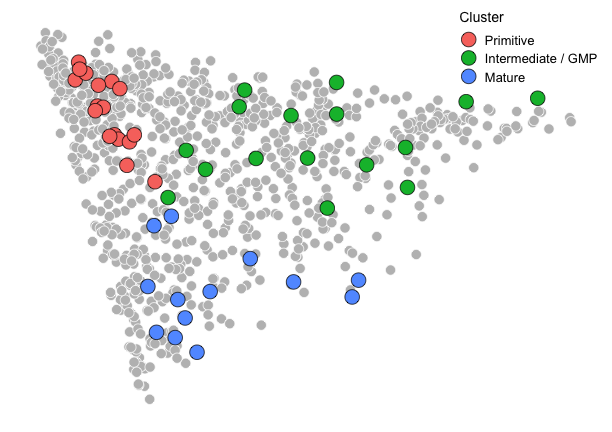

In [298]:
%%R -i ref -i dat  -h 6 -w 8.5 --units in
library(tidyverse)
library(ggpubr)

dat_combined <- dat %>% 
    mutate(Cluster = factor(Cluster, levels=c('Primitive', 'Intermediate / GMP', 'Mature'))) %>%
    full_join(ref)
    
dat_combined %>% 
    ggplot(aes(x = PC1, y = -PC2)) + 
    geom_point(data = subset(dat_combined, is.na(Patient)), size=4.5, shape=21, fill ='grey', color='white') + 
    geom_point(data = subset(dat_combined, !is.na(Patient)), aes(fill = `Cluster`), size=6.5, shape=21, color='black') + 
    #scale_fill_manual(palette='Dark2') +
    theme_void() + 
    theme(legend.title = element_text(size = 14), 
          legend.text = element_text(size = 13), 
          legend.position = c(1, 1.01),
          legend.justification = c("right", 'top'),
          plot.margin = unit(c(1, 1, 1, 1), "lines")) #+ ggsave("figures/DxRx_All_Hierarchy_linked.png", dpi='retina', height=6, width=8.2)

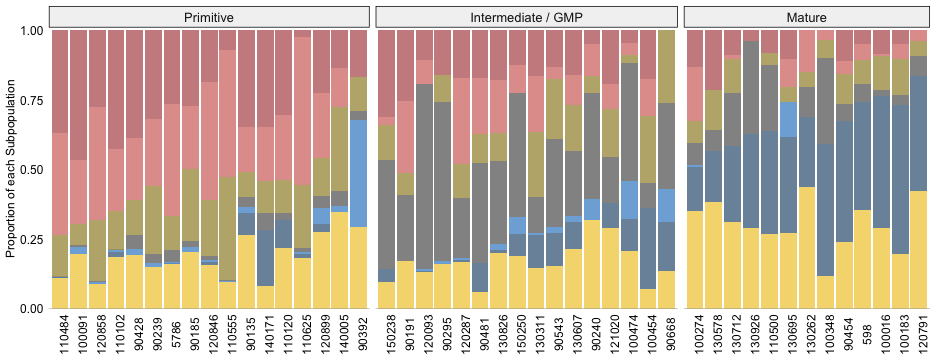

In [299]:
%%R -i results -h 5 -w 13 --units in

hierarchy_colors = c('#A7303099', '#CD534C99', '#8F770099', '#3B3B3B99', '#0073C299', '#003C6799', '#EFC00099')

populations <- results %>% 
    mutate(Patient = Patient %>% as.character()) %>%
    mutate(Patient = factor(Patient, levels = arrange(., `PC2`)$Patient)) %>% 
    mutate(Cluster = factor(Cluster, levels = c('Primitive', 'Intermediate / GMP', 'Mature'))) %>% 
    gather(-Patient, -Sample, -`CC90009 Response`, -`Fed Response`, -Cluster, -`CC90009 RF Reduction`, -`Fed RF Reduction`, -PC1, -PC2, key='Population', value='prop') %>% 
    mutate(Population = Population %>% str_replace('-Relative', ''), 
           Population = factor(Population, levels = c("LSPC-Quiescent", "LSPC-Primed", "LSPC-Cycle", 
                                                    "GMP-like", "ProMono-like", "Mono-like", "cDC-like")))

populations %>% 
   ggplot(aes(x=Patient, y=prop, fill=Population)) +
       geom_col() + 
       scale_fill_manual(values = hierarchy_colors) + 
       ylab("Proportion of each Subpopulation") + 
       theme_pubr() +
       scale_y_continuous(expand = c(0, 0), limits = c(0, 1.01)) +
       facet_grid(.~Cluster, scales="free_x", space = "free_x") + 
        theme(legend.position = "none", axis.title.x = element_blank(), axis.ticks = element_blank(), axis.text.x = element_text(angle=90, size=12),
            strip.text.x = element_text(size = 13), axis.line.x = element_line(colour = 'black', size = 0.1), axis.line.y = element_blank())


`summarise()` regrouping output by 'Patient' (override with `.groups` argument)
Joining, by = c("PC1", "PC2")


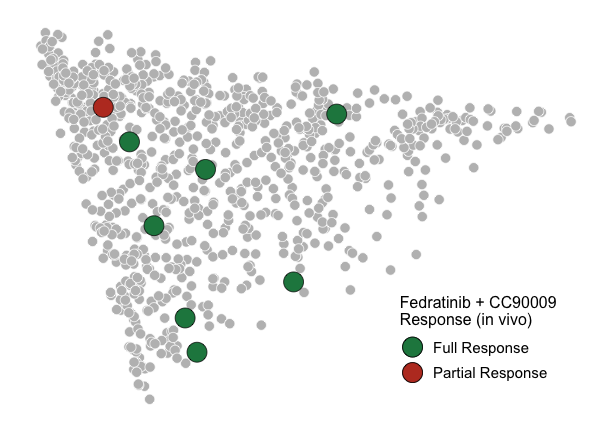

In [300]:
%%R -i ref -i dat  -h 6 -w 8.5 --units in

## Combo Treated - #######
###########################
###########################
###########################
###########################
###########################
library(tidyverse)
library(ggpubr)

dat_combined <- dat %>% 
    group_by(Patient, `Fedratinib + CC90009\nResponse (in vivo)`) %>% 
    summarise(PC1 = mean(PC1),
              PC2 = mean(PC2)) %>% 
    full_join(ref)
    
dat_combined %>% 
    ggplot(aes(x = PC1, y = -PC2)) + 
    geom_point(data = subset(dat_combined, is.na(Patient)), size=4.5, shape=21, fill ='grey', color='white') + 
    geom_point(data = subset(dat_combined, `Fedratinib + CC90009\nResponse (in vivo)` %in% c("Full Response")), aes(fill = `Fedratinib + CC90009\nResponse (in vivo)`), size=9, shape=21, color='black') + 
    geom_point(data = subset(dat_combined, `Fedratinib + CC90009\nResponse (in vivo)` %in% c("Partial Response")), aes(fill = `Fedratinib + CC90009\nResponse (in vivo)`), size=9, shape=21, color='black') + 
    scale_fill_manual(values=c('#20854EFF', '#BC3C29FF')) +
    theme_void() + 
    theme(legend.title = element_text(size = 16), 
          legend.text = element_text(size = 15), 
          legend.position = c(0.93, 0.08),
          legend.justification = c("right", 'bottom'),
          plot.margin = unit(c(1, 1, 1, 1), "lines")) #+ ggsave("figures/DxRx_All_Hierarchy_linked.png", dpi='retina', height=6, width=8.2)

## Show expression of Fedratinib and CC-90009 targets from scRNA-seq 

In [305]:
# Load Malignant scRNA-seq
malignant = sc.read_h5ad("Data/scAML_malignant_newclust.h5ad")
# Re-order malignant cell types 
malignant.obs.Cluster = malignant.obs.Cluster.cat.set_categories(['LSPC-Quiescent', 'LSPC-Primed', 'LSPC-Cycle', 'GMP-like', 'ProMono-like', 'Mono-like', 'cDC-like'])
malignant

AnnData object with n_obs × n_vars = 11641 × 17466
    obs: 'NumberOfReads', 'AlignedToGenome', 'AlignedToTranscriptome', 'TranscriptomeUMIs', 'NumberOfGenes', 'CyclingScore', 'CyclingBinary', 'MutTranscripts', 'WtTranscripts', 'PredictionRF2', 'PredictionRefined', 'CellType', 'Score_HSC', 'Score_Prog', 'Score_GMP', 'Score_ProMono', 'Score_Mono', 'Score_cDC', 'Score_pDC', 'Score_earlyEry', 'Score_lateEry', 'Score_ProB', 'Score_B', 'Score_Plasma', 'Score_T', 'Score_CTL', 'Score_NK', 'NanoporeTranscripts', 'batch', 'is_cell_control', 'total_features_by_counts', 'log10_total_features_by_counts', 'total_counts', 'log10_total_counts', 'pct_counts_in_top_50_features', 'pct_counts_in_top_100_features', 'pct_counts_in_top_200_features', 'pct_counts_in_top_500_features', 'HALLMARK_TNFA_SIGNALING_VIA_NFKB', 'HALLMARK_HYPOXIA', 'HALLMARK_CHOLESTEROL_HOMEOSTASIS', 'HALLMARK_MITOTIC_SPINDLE', 'HALLMARK_WNT_BETA_CATENIN_SIGNALING', 'HALLMARK_TGF_BETA_SIGNALING', 'HALLMARK_IL6_JAK_STAT3_SIGNALING', '

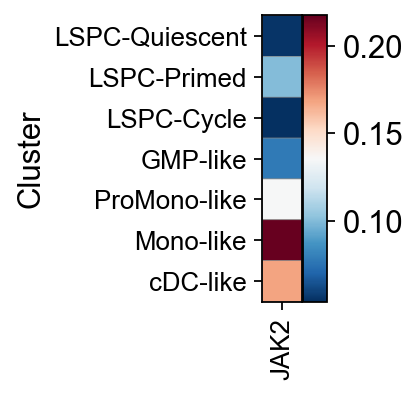

GridSpec(2, 3, height_ratios=[0, 10.5], width_ratios=[0.32, 0, 0.2])

In [306]:
# Fedratinib Target: JAK2
sc.pl.matrixplot(malignant, var_names=['JAK2'], groupby='Cluster', cmap='RdBu_r')

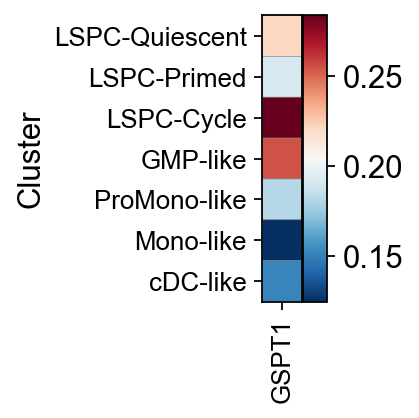

GridSpec(2, 3, height_ratios=[0, 10.5], width_ratios=[0.32, 0, 0.2])

In [307]:
# CC-90009 Target: GSPT1
sc.pl.matrixplot(malignant, var_names=['GSPT1'], groupby='Cluster', cmap='RdBu_r')